In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii 
from astropy import units as u

In [2]:
tab = astropy.io.ascii.read("/Users/huihaoz/Downloads/PS_2023.02.22_19.19.00.csv")

## calculate contrast and separation

In [7]:
contrast_arr = np.zeros((len(tab)))
sma_arr = np.zeros((len(tab)))
sep_arr = np.zeros((len(tab)))
rad_arr = np.zeros((len(tab)))
dis_arr = np.zeros((len(tab)))

def cal_rad(mass):
    if mass < (2.0 * u.earthMass):
        rad = (((mass / (1.0 * u.earthMass)).decompose())**(0.28) * u.earthRad).to(u.jupiterRad)
    elif mass < (0.41 * u.jupiterMass):
        rad = (((mass / (14.5 * u.earthMass)).decompose())**(0.59) * (4.01 * u.earthRad)).to(u.jupiterRad)
    elif mass < (0.08 * u.solMass):
        rad = ((mass / (1 * u.jupiterMass)).decompose())**(-0.04) * (1.1 * u.jupiterRad)
    else:
        rad = ((mass / (0.08 * u.solMass)).decompose())**(0.88) * (0.95 * u.jupiterRad) 
    return(rad)

k = 0
for i, tmp in enumerate(tab["pl_name"]):
    if tab["pl_orbper"].mask[i] == False:
        # calculating sma
        if tab["pl_orbsmax"].mask[i] == True:
            if tab["st_mass"].mask[i] == True:
                sma = ((tab["pl_orbper"][i] / 365.0)**2 * 1.0)**(0.33) * u.AU
            else:
                sma = ((tab["pl_orbper"][i] / 365.0)**2 * tab["st_mass"][i])**(0.33) * u.AU
        else:
            sma = tab["pl_orbsmax"][i] * u.AU

        # calculating angular separation
        if tab["sy_dist"].mask[i] == True:
            if tab["sy_dist"].mask[i] == True:
                dis = 999 * u.parsec
            else:
                dis = tab["sy_dist"][i] * u.parsec
        else:
            dis = tab["sy_dist"][i] * u.parsec
        sep = ((sma / dis).decompose() * u.radian).to(u.arcsec)

        # calculating planet radius, https://arxiv.org/pdf/1603.08614.pdf
        if tab["pl_radj"].mask[i] == True:
            if tab["pl_bmassj"].mask[i] == False:
                mass = tab["pl_bmassj"][i] * u.jupiterMass
                rad = cal_rad(mass)
            else:
                rad = 1.0 * u.jupiterRad
        else:
            rad = tab["pl_radj"][i] * u.jupiterRad

        # calculating contrast
        albedo = 0.3
        con = ((rad / sma).decompose())**2 * albedo


        if (con > 1e-7) & (sep.value > 5e-3) & (tab["dec"][i] > -100.0) & (rad < (0.2 * u.jupiterRad)):
#             print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
#                   dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i], \
#                   tab["st_k"][i], tab["st_wise1"][i])
            k = k + 1
#         elif tab["pl_name"][i] == "Ross 128 b":
#              print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
#                   dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i])           
        else:
            1 == 1

        sma_arr[i] = sma.value
        sep_arr[i] = sep.value
        rad_arr[i] = rad.value
        contrast_arr[i] = con
        dis_arr[i] = dis.value
    else:
        sma_arr[i] = 1.0
        sep_arr[i] = 1e-5
        rad_arr[i] = 1.0
        contrast_arr[i] = 1e-10       
        dis_arr[i] = 1e3

## Plot seleted targets

In [9]:
# define the temprature of the suitable planets fron NEA
temp = [183.707, 224.199, 365.493, 319.321, 266.145, 355.467, 306.961, 240.079, 258.630, 427.655, 217.185, 282.712, 201.836, 275.106]

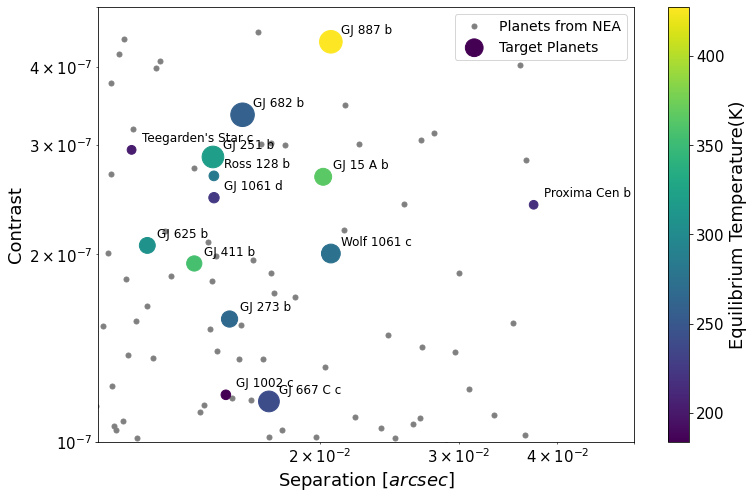

In [57]:
lambda_D = (((2.0 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec) #angular seperation baseline
con_threshold = 1e-7 #baseline for contrast
sep_threshold = lambda_D.value
rad_threshold = 0.2
fig, ax = plt.subplots(figsize=(12, 8))

font_size = 18

#find the planets which meet the requierment
ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold) & (rad_arr < 0.2))
rot_arr = np.zeros((len(contrast_arr[ind]), ))
for ii, i in enumerate(np.array(ind).flatten()):
    if (tab["dec"][i] > 0.0):
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.03, contrast_arr[i] * 1.03), rotation=rot_arr[ii], color="black",size=12)
    else:
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.03, contrast_arr[i] * 1.03), rotation=rot_arr[ii], color="black",size=12)

plt.plot(sep_arr, contrast_arr, 'o',color="grey",ms=5,label="Planets from NEA",zorder=-1)

sc =plt.scatter(sep_arr[ind], contrast_arr[ind],s=rad_arr[ind]**3 * 100000,c=temp,label="Target Planets",zorder=1)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Equilibrium Temperature(K)',size=18)
fig.patch.set_facecolor('white')
plt.legend( prop={'size': 14})
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'Separation [$arcsec$]', fontsize=font_size)
plt.ylabel(r'Contrast', fontsize=font_size)
plt.xlim(lambda_D.value, 5e-2)
plt.ylim(1e-7, 0.5e-6)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
